In [ ]:
!pip install fastai
!pip install transformers

In [ ]:
import fastai
import transformers
print('fastai version :', fastai.__version__)
print('transformers version :', transformers.__version__)

fastai version : 1.0.61
transformers version : 4.15.0


In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path 
import os
import torch
import torch.optim as optim
import random 
# fastai
from fastai import *
from fastai.text import *
from fastai.callbacks import *

from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig
from transformers import BertForMaskedLM, BertTokenizer, pipeline, BertForSequenceClassification, BertConfig

In [ ]:
from google.colab import files
from google.colab import drive
drive._mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
torch.cuda.is_available()

True

In [ ]:
DATA_ROOT = Path(os.getcwd())/'gdrive'/'MyDrive'/'Thesis Data'/'Our dataset' #Path("./")
BBert = DATA_ROOT/'BanglaBert'
baad16 = pd.read_csv(DATA_ROOT / 'full.csv')
baad16_train = pd.read_csv(DATA_ROOT / 'OurDataset_train.csv')
baad16_test = pd.read_csv(DATA_ROOT / 'OurDataset_test.csv')
print(baad16.shape, baad16_train.shape,baad16_test.shape)
baad16.head()

(17966, 3) (14374, 3) (3592, 3)


,label,text,is_valid
0,manik_bandhopaddhay,চাহিয়া থাকে। একজন স্ত্রীলোককে পাওয়ার লোভে তার ...,False
1,manik_bandhopaddhay,"বীভৎস অস্বাভাবিকতার সিন্ধু খুঁজিয়া মেলে, রোমাঞ...",False
2,manik_bandhopaddhay,"আছে। ধাক্কা দেওয়ার, গা মাড়াইয়া দেওয়ার বচসা আর ...",False
3,manik_bandhopaddhay,উপর সদানন্দের অনুপ্রেরণা। একটা গৰ্জনের মতো আওয়...,False
4,manik_bandhopaddhay,"প্রমাণ নয়? ভাবিতে ভাবিতে বিভূতি বুঝিতে পারি, ম...",False


In [ ]:
# Parameters
seed = 42
use_fp16 = False
bs = 6
model_name = "sagorsarker/bangla-bert-base"

In [ ]:
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  # needed
        torch.backends.cudnn.benchmark = False

In [ ]:
seed_all(seed)

In [ ]:
class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = 512 # pretrained_tokenizer.model_max_length (it's wrongly set in the model config)
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the special tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
        return [CLS] + tokens + [SEP]

In [ ]:
transformer_tokenizer = BertTokenizer.from_pretrained(model_name)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = 'bert')
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

Downloading:   0%|          | 0.00/2.13M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/491 [00:00<?, ?B/s]

In [ ]:
transformer_tokenizer.cls_token, transformer_tokenizer.sep_token

('[CLS]', '[SEP]')

In [ ]:
# tokenizer_class.pretrained_vocab_files_map
transformer_tokenizer

PreTrainedTokenizer(name_or_path='sagorsarker/bangla-bert-base', vocab_size=101975, model_max_len=1000000000000000019884624838656, is_fast=False, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [ ]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)

In [ ]:
transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)
tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)
transformer_processor = [tokenize_processor, numericalize_processor]

In [ ]:
pad_first = bool(model_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id

In [ ]:
databunch = (TextList.from_df(baad16_train, cols='text', processor=transformer_processor)
             .split_by_rand_pct(0.1,seed=seed)
             .label_from_df(cols= 'label')
             .add_test(baad16_test)
             .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
databunch.show_batch()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


text,target
[CLS] কলকারখানা ? আরও য ##ন ##তর - নির ##ভরত ##া ? আরও আরাম - আয ##েস ? অগ ##র ##গমন মানে কি সমকামিতা আর বিবাহ বরজ ##ন ? অগ ##র ##গমন কি মান ##ষক ##ে বাচ ##তে শিখি ##যে ##ছে ? অন ##ধা ##বন করতে শিখি ##যে ##ছে পর ##কতি ##র নি ##যম ##ানস ##ারে জীবনের ধা ##চ গড ##ে নিতে ? সভ ##যত ##া কি কা ##ণ ##ডজ,shirshendu
"[CLS] গল ##প পাঠালে যে ##হে ##ত আমি গল ##প লেখক বলে পরিচিত নই , আমার গল ##প মড ##ির ঠে ##া ##ঙার মত কচ ##কে ফেলে দেও ##যা হয হাবি ##জিবি কাগজের ঝ ##ডি ##তে । এরশাদকে কষ ##মতা ##চ ##যত করতে রাজনৈতিক জে ##াট ##ের সভা চলছে , মিছিলে কাপ ##ছে নগরী । বিশ ##বব ##িদ ##যা ##ল ##যে ##র রাজনৈতিক ছাত ##র ##ছা ##তরী সংগঠনও বড ভ",toslima_nasrin
"[CLS] আবার চলতে শর করবে । এক পথ থেকে আরেক পথ । অন ##য পথের মে ##াড ##ে । বড ##ে ##া আহমদ হে ##াসে ##ন তখন ##ে ##া কাদ ##ছে । চা ##যে ##র দাম চক ##িয ##ে দি ##যে কি ##ছ ##কষ ##ণ পরে বাইরে বেরি ##যে এলে ##া শওকত । ল ##মবা দেহ । ছিপছিপে শরীর । দর থেকে দেখলে মনে হয , বাতাসের ভার সহ ##য",zahir_rayhan
"[CLS] জ ##যন ##ত সিগারেট খা ##চ ##ছে , পর ##কাশ ##যে ##ই । ধরব যত ##দর জানে , জ ##যন ##ত সিগারেট খা ##য না । এখন খা ##চ ##ছে সম ##ভব ##ত ভিতরকার উদ ##বেগ - উৎ ##ক ##ণ ##ঠা ##কে সামাল দেও ##যার জন ##য ##ই । একবার ধরব ##র দিকে একট তাকি ##যে চে ##াখ সরি ##যে নিল । ঘণ ##ায ? ভ ##যে ? কে",shirshendu
"[CLS] কি করবে মনে কর ? কি আমাকে আপনি করতে বলেন ? তে ##ামা ##কে ? বলি ##যা জীব ##ান ##নদ সত ##বধ নত ##ম ##খে বসি ##যা তৈল ##বির ##ল পর ##দীপ ##ের বাতি ##টা অকারণে শ ##ধ শ ##ধ কেবল উস ##কাই ##তে লাগিল । খানিক পরে যখন সে কথা কহিল , তখনও তাহার চক ##ষ সেই দীপশিখা ##র পরত ##ি । কহিল , তাহলে এরা সকলে তে",shorotchandra


In [ ]:
databunch.train_dl.classes

['MZI',
 'bongkim',
 'humayun_ahmed',
 'manik_bandhopaddhay',
 'nazrul',
 'nihar_ronjon_gupta',
 'robindronath',
 'shirshendu',
 'shomresh',
 'shordindu',
 'shorotchandra',
 'shottojit_roy',
 'shunil_gongopaddhay',
 'tarashonkor',
 'toslima_nasrin',
 'zahir_rayhan']

In [ ]:
len(databunch.train_dl.classes)

16

In [ ]:
# defining our model architecture 
class CustomTransformerModel(nn.Module):
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model
        
    def forward(self, input_ids, attention_mask=None):
        logits = self.transformer(input_ids,attention_mask = attention_mask)[0]   
        return logits

In [ ]:
config = BertConfig.from_pretrained(model_name)
config.num_labels = len(databunch.train_dl.classes)
config.use_bfloat16 = use_fp16
print(config)

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_10": 10,
    "LABEL_11": 11,
    "LABEL_12": 12,
    "LABEL_13": 13,
    "LABEL_14": 14,
    "LABEL_15": 15,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8,
    "LABEL_9": 9
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "

In [ ]:
transformer_model = BertForSequenceClassification.from_pretrained(model_name, config = config)
custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)

Downloading:   0%|          | 0.00/630M [00:00<?, ?B/s]

Some weights of the model checkpoint at sagorsarker/bangla-bert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

In [ ]:
from fastai.callbacks import *
from transformers import AdamW

learner = Learner(databunch, 
                  custom_transformer_model, 
                  opt_func = lambda input: AdamW(input,correct_bias=False), 
                  metrics=[accuracy])

# Show graph of learner stats and metrics after each epoch.
learner.callbacks.append(ShowGraph(learner))

# Put learn in FP16 precision mode. --> Seems to not working
if use_fp16: learner = learner.to_fp16()

In [ ]:
print(learner.model)

CustomTransformerModel(
  (transformer): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(102025, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_featur

We can decide to divide the model in 14 blocks :
* 1 Embedding
* 12 transformer
* 1 classifier

(same for bert)
In this case, we can split our model in this way :

In [ ]:
# For bert-base
list_layers = [learner.model.transformer.bert.embeddings,
              learner.model.transformer.bert.encoder.layer[0],
              learner.model.transformer.bert.encoder.layer[1],
              learner.model.transformer.bert.encoder.layer[2],
              learner.model.transformer.bert.encoder.layer[3],
              learner.model.transformer.bert.encoder.layer[4],
              learner.model.transformer.bert.encoder.layer[5],
              learner.model.transformer.bert.encoder.layer[6],
              learner.model.transformer.bert.encoder.layer[7],
              learner.model.transformer.bert.encoder.layer[8],
              learner.model.transformer.bert.encoder.layer[9],
              learner.model.transformer.bert.encoder.layer[10],
              learner.model.transformer.bert.encoder.layer[11],
              learner.model.transformer.bert.pooler]

Check groups : 

In [ ]:
learner.split(list_layers)
num_groups = len(learner.layer_groups)
print('Learner split in',num_groups,'groups')
# print(learner.layer_groups)

Learner split in 14 groups


### Train
Now we can finally use all the fastai build-in features to train our model. Like the ULMFiT method, we will use **Slanted Triangular Learning Rates**, **Discriminate Learning Rate** and **gradually unfreeze the model**.

In [ ]:
# !mkdir "{BBert}"

In [ ]:
# learner.save('aa1/untrain')
# seed_all(seed)
# learner.load('aa1/untrain');

In [ ]:
# freeze all the groups but the classifier
learner.freeze_to(-1)

In [ ]:
# We check which layer are trainable
learner.summary()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


CustomTransformerModel
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [512, 768]           78,355,200 False     
______________________________________________________________________
Embedding            [512, 768]           393,216    False     
______________________________________________________________________
Embedding            [512, 768]           1,536      False     
______________________________________________________________________
LayerNorm            [512, 768]           1,536      False     
______________________________________________________________________
Dropout              [512, 768]           0          False     
______________________________________________________________________
Linear               [512, 768]           590,592    False     
______________________________________________________________________
Linear               [512, 768]           590,592    False     
_______________________________________

epoch,train_loss,valid_loss,accuracy,time


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-06
Min loss divided by 10: 5.75E-05


1.3182567385564074e-06

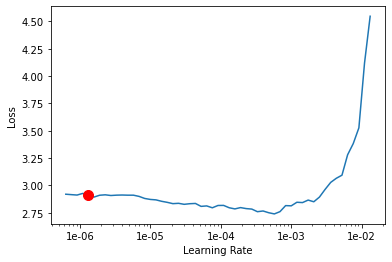

In [ ]:
learner.lr_find()
learner.recorder.plot(skip_end=7,suggestion=True)
lr = learner.recorder.min_grad_lr
lr

epoch,train_loss,valid_loss,accuracy,time
0,2.485453,2.474540,0.249130,16:40
1,2.276669,2.322513,0.252610,16:44
2,2.226253,2.231740,0.295755,16:43
3,2.219204,2.190598,0.308977,16:42
4,2.228355,2.184379,0.311761,16:41


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


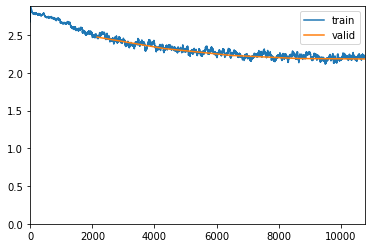

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

In [ ]:
lr = 1.3182567385564074e-06
learner.fit_one_cycle(5,max_lr=lr,moms=(0.8,0.7))
learner.save(BBert/'epoch_5')

epoch,train_loss,valid_loss,accuracy,time


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 7.59E-06


epoch,train_loss,valid_loss,accuracy,time
0,1.930128,1.969235,0.386917,18:14
1,1.900309,1.887633,0.417537,18:15


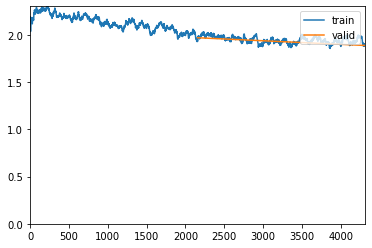

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


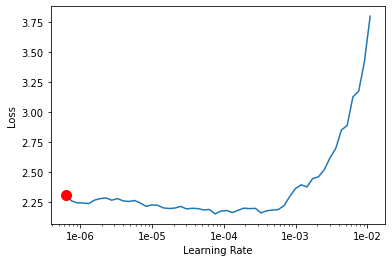

In [ ]:
learner.load(BBert/'epoch_5')
learner.freeze_to(-2)
learner.lr_find()
learner.recorder.plot(skip_end=7,suggestion=True)
lr = learner.recorder.min_grad_lr
learner.fit_one_cycle(2, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))
learner.save(BBert/'epoch_7')

epoch,train_loss,valid_loss,accuracy,time


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 8.32E-07


epoch,train_loss,valid_loss,accuracy,time
0,1.569099,1.593528,0.505915,45:20
1,1.181690,1.181655,0.640223,45:18
2,1.011282,0.958328,0.737648,45:17


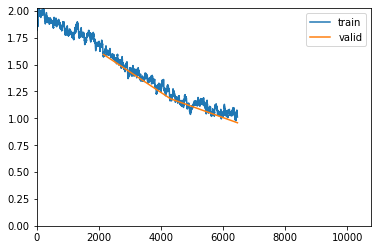

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

epoch,train_loss,valid_loss,accuracy,time
0,1.569099,1.593528,0.505915,45:20
1,1.181690,1.181655,0.640223,45:18
2,1.011282,0.958328,0.737648,45:17


In [ ]:
learner.load(BBert/'epoch_7')
learner.unfreeze()
learner.lr_find()
learner.recorder.plot(skip_end=7,suggestion=True)
lr = learner.recorder.min_grad_lr
# lr = 6.31E-07
learner.fit_one_cycle(5, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))
learner.save(BBert/'epoch_12')

In [ ]:
learner.load(BBert/'epoch_12')
learner.unfreeze()
learner.fit_one_cycle(5, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))
learner.save(BBert/'epoch_17')

In [ ]:
learner.load(BBert/'epoch_17')
learner.unfreeze()
learner.fit_one_cycle(5, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))
learner.save(BBert/'epoch_22')

### Creating prediction
Now that the model is trained, we want to generate predictions from the test dataset.

In [ ]:
def testing(df):
    text_array = df["text"].tolist()
    print(len(text_array))

    final_preds = []

    for text in text_array:
      preds = learner.predict(text)
      final_preds.append(str(preds[0]))

    targets = df["label"].tolist()

    err=[]
    count =0;
    tst = len(text_array)

    for i in range(tst):
        if(targets[i]==final_preds[i]):
          count = count+1
        else:
          err.append((targets[i],final_preds[i]))
    print("Accuracy: ")
    print(count/tst)
    print(err)

    return final_preds,targets

In [ ]:
pred,targ = testing(test)

3592
Accuracy: 
0.9479398663697105
[('shunil_gongopaddhay', 'shottojit_roy'), ('shunil_gongopaddhay', 'humayun_ahmed'), ('shomresh', 'MZI'), ('toslima_nasrin', 'manik_bandhopaddhay'), ('shirshendu', 'shunil_gongopaddhay'), ('shordindu', 'robindronath'), ('shottojit_roy', 'MZI'), ('robindronath', 'bongkim'), ('shomresh', 'shirshendu'), ('humayun_ahmed', 'toslima_nasrin'), ('humayun_ahmed', 'MZI'), ('shirshendu', 'shottojit_roy'), ('shordindu', 'nihar_ronjon_gupta'), ('shordindu', 'MZI'), ('bongkim', 'shorotchandra'), ('manik_bandhopaddhay', 'MZI'), ('humayun_ahmed', 'toslima_nasrin'), ('robindronath', 'nazrul'), ('humayun_ahmed', 'MZI'), ('nihar_ronjon_gupta', 'MZI'), ('manik_bandhopaddhay', 'toslima_nasrin'), ('shorotchandra', 'robindronath'), ('tarashonkor', 'nihar_ronjon_gupta'), ('shordindu', 'tarashonkor'), ('nihar_ronjon_gupta', 'shunil_gongopaddhay'), ('nazrul', 'toslima_nasrin'), ('shirshendu', 'shomresh'), ('robindronath', 'shordindu'), ('manik_bandhopaddhay', 'MZI'), ('shomres